In [1]:
import numpy as np 
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('train.csv', encoding='ISO-8859-1', header= None)
dataset = dataset.rename(index=str, columns={ 0: "review", 1: "aspect_category", 2: "sentiment"})
data = dataset[['review','aspect_category']]
data.head(5)

,review,aspect_category
0,I have heard many stories of them helping empl...,environment
1,"give you advice, support, and overall super fr...",environment
2,Everyone I work with is willing to help when y...,environment
3,The company provides you with a ton of resourc...,environment
4,it is a very transparent workplace that offers...,environment


In [3]:
import spacy
nlp = spacy.load('en')

dataset.review = dataset.review.str.lower()

aspect_terms = []
for review in nlp.pipe(dataset.review):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset['aspect_terms'] = aspect_terms
dataset.head(10)

,review,aspect_category,sentiment,aspect_terms
0,i have heard many stories of them helping empl...,environment,Positive,stories employees what companies circumstances
1,"give you advice, support, and overall super fr...",environment,Positive,advice support
2,everyone i work with is willing to help when y...,environment,Positive,everyone
3,the company provides you with a ton of resourc...,environment,Positive,company ton resources benefits
4,it is a very transparent workplace that offers...,environment,Positive,workplace employees ability
5,work/life balance. what balance? all those per...,environment,Negative,balance what perks benefits illusion
6,. i've never met anybody at google who actuall...,environment,Negative,anybody who weekends vacations
7,"""you have to work on weekends/vacations"" but, ...",environment,Negative,vacations culture
8,do something about that work-ife balance.,environment,Negative,something balance
9,you can't find a more well-regarded company th...,environment,Positive,company hype


In [4]:
max_fatures = 6000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['aspect_terms'].values)
X = tokenizer.texts_to_sequences(dataset['aspect_terms'].values)
X = pad_sequences(X)

In [8]:
Y = pd.get_dummies(dataset['aspect_category']).values
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
(527, 6) (527, 3)
(132, 6) (132, 3)


In [10]:
epochs = 10
emb_dim = 128
batch_size = 256

model = Sequential()
model.add(Embedding(max_fatures, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 6, 128)            768000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 6, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 817,603
Trainable params: 817,603
Non-trainable params: 0
_________________________________________________________________
None
Train on 421 samples, validate on 106 samples
Epoch 1/10
421/421 [==============================] - ETA: 1s - loss: 1.1024 - acc: 0.343 - 2s 5ms/step - loss: 1.1013 - acc: 0.3373 - val_loss: 1.0988 - val_acc: 0.3302
Epoch 2/10
421/421 [===========================

<Figure size 432x288 with 0 Axes>

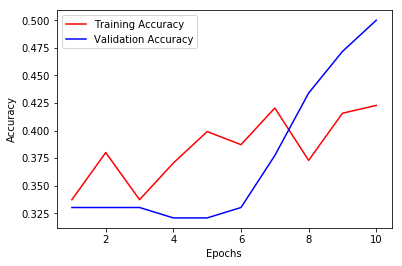

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color = 'red', label='Training acc')
plt.plot(epochs, val_acc, color = 'blue', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.figure()

In [13]:
import numpy as np 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


y_predict = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_predict ]

matrix = confusion_matrix(y_test_non_category, y_predict_non_category)
print(matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_non_category, y_predict_non_category)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_non_category, y_predict_non_category,average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_non_category, y_predict_non_category,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_non_category, y_predict_non_category,average='macro')
print('F1 score: %f' % f1)

[[23 28  0]
 [ 0 44  0]
 [ 5 32  0]]
Accuracy: 0.507576


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.414835
Recall: 0.483660


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score: 0.392291


In [17]:
txt = ["Good place to learn new technologies"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['environment', 'leadeship', 'learning']
print(pred, labels[np.argmax(pred)])

[[0.57680476 0.1647595  0.2584357 ]] environment
